In [1]:
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("TCGA_expression_survival.csv", index_col = 0)
data.head()

,node,sex,race,ethnicity,history_other_malignancy.x,margin_status,status,age,hpv_status,site,...,TWIST1_7291,UCHL1_7345,VAV1_7409,VIM_7431,WIF1_11197,WISP1_8840,ZAP70_7535,ZCCHC14_23174,ZMYND10_51364,ZNF582_147948
Index,,,,,,,,,,,,,,,,,,,,,
1,2,1,3.0,2.0,1,1.0,1,66,1,2,...,450.4699,762.2862,470.8057,32202.6252,0.0000,222.4619,160.2218,680.3266,6.7786,17.2547
2,2,1,4.0,2.0,1,3.0,2,69,1,2,...,292.1193,554.5643,36.6113,14629.8601,0.7708,701.7801,82.0863,251.2689,5.0100,16.9568
3,1,1,3.0,2.0,2,3.0,2,49,1,2,...,144.7139,209.5672,52.5258,5891.3842,0.0000,207.9593,3.7518,311.9389,9.1116,4.2878
5,1,2,4.0,2.0,2,1.0,2,45,2,3,...,144.8508,1848.4119,361.4052,13008.3397,19.7305,98.6526,118.3831,501.9249,1.9249,8.1809
7,2,1,4.0,2.0,1,1.0,1,47,1,2,...,114.3053,34.5654,73.2375,26226.9576,0.0000,151.2663,43.4634,2098.9049,7.1869,2.0534


In [3]:
data.shape

(408, 162)

In [4]:
data["status"] = data["status"] - 1
data["sex"] = data["sex"] - 1

In [5]:
data.head()

,node,sex,race,ethnicity,history_other_malignancy.x,margin_status,status,age,hpv_status,site,...,TWIST1_7291,UCHL1_7345,VAV1_7409,VIM_7431,WIF1_11197,WISP1_8840,ZAP70_7535,ZCCHC14_23174,ZMYND10_51364,ZNF582_147948
Index,,,,,,,,,,,,,,,,,,,,,
1,2,0,3.0,2.0,1,1.0,0,66,1,2,...,450.4699,762.2862,470.8057,32202.6252,0.0000,222.4619,160.2218,680.3266,6.7786,17.2547
2,2,0,4.0,2.0,1,3.0,1,69,1,2,...,292.1193,554.5643,36.6113,14629.8601,0.7708,701.7801,82.0863,251.2689,5.0100,16.9568
3,1,0,3.0,2.0,2,3.0,1,49,1,2,...,144.7139,209.5672,52.5258,5891.3842,0.0000,207.9593,3.7518,311.9389,9.1116,4.2878
5,1,1,4.0,2.0,2,1.0,1,45,2,3,...,144.8508,1848.4119,361.4052,13008.3397,19.7305,98.6526,118.3831,501.9249,1.9249,8.1809
7,2,0,4.0,2.0,1,1.0,0,47,1,2,...,114.3053,34.5654,73.2375,26226.9576,0.0000,151.2663,43.4634,2098.9049,7.1869,2.0534


In [6]:
data.dtypes

node                            int64
sex                             int64
race                          float64
ethnicity                     float64
history_other_malignancy.x      int64
                               ...   
WISP1_8840                    float64
ZAP70_7535                    float64
ZCCHC14_23174                 float64
ZMYND10_51364                 float64
ZNF582_147948                 float64
Length: 162, dtype: object

In [7]:
data.isnull().sum()

node                           0
sex                            0
race                          13
ethnicity                     30
history_other_malignancy.x     0
                              ..
WISP1_8840                     0
ZAP70_7535                     0
ZCCHC14_23174                  0
ZMYND10_51364                  0
ZNF582_147948                  0
Length: 162, dtype: int64

In [8]:
for col in ['status','node', 'sex', 'race', 'ethnicity','history_other_malignancy.x','margin_status','hpv_status','site','ever_smoker']:
    data[col] = data[col].astype('category')

data.dtypes

node                          category
sex                           category
race                          category
ethnicity                     category
history_other_malignancy.x    category
                                ...   
WISP1_8840                     float64
ZAP70_7535                     float64
ZCCHC14_23174                  float64
ZMYND10_51364                  float64
ZNF582_147948                  float64
Length: 162, dtype: object

In [9]:
# PREPROCESSING STEPS FOR NUMERICAL AND CATEGORICAL FEATURES

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# this gets the numeric features as a list, these will either be an integer or a float
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns

# similarly this gets the categorical features as a list. these are strings and not numbers, for example could be 'yes' or 'no'
categorical_features = data.select_dtypes(include=['object']).columns

# !!!PUT YOUR IMPUTER AND SCALERS FOR THE NUMERICAL DATA HERE!!!:
# here we replace every missing or NaN value with the mean of the features
NUMERICAL_IMPUTER = SimpleImputer(strategy='mean')
# here we scale every feature such that its mean is 0 and standard deviation is 1
NUMERICAL_SCALER = StandardScaler()

numeric_transformer = Pipeline(steps=[
    ('imputer', NUMERICAL_IMPUTER), # here we replace every missing or NaN value with the mean of the features
    ('scaler', NUMERICAL_SCALER) # here we scale every feature such that its mean is 0 and standard deviation is 1
])


# this defines how we want to transform the categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # here we replace every missing or NaN value with the most commonly occuring label
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # this converts the categorical variables
])


# this now applies the column transforms we just defined
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features), # define the process as the name 'num', and tell sklearn to apply the numeric transformer we defined the the numeric features we got into the list
        ('cat', categorical_transformer, categorical_features) # same with the categorical variables
    ])


In [10]:
data.isnull().sum()

node                           0
sex                            0
race                          13
ethnicity                     30
history_other_malignancy.x     0
                              ..
WISP1_8840                     0
ZAP70_7535                     0
ZCCHC14_23174                  0
ZMYND10_51364                  0
ZNF582_147948                  0
Length: 162, dtype: int64

In [11]:
data.shape

(408, 162)

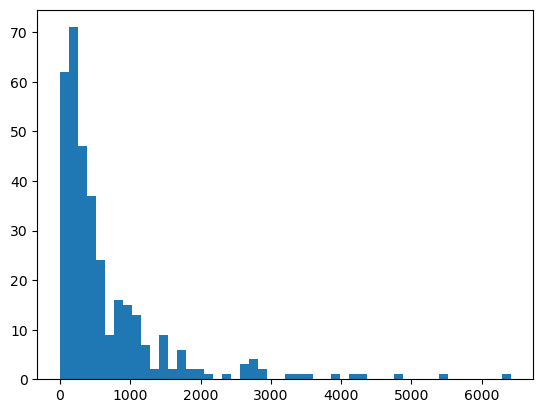

<Axes: xlabel='timeline'>

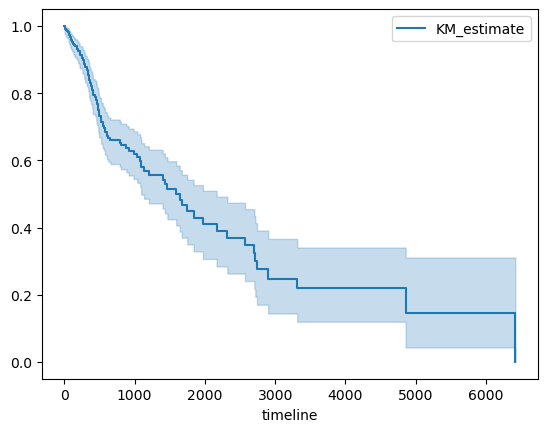

In [12]:
data_cleaned = data.dropna()
T = data_cleaned["time"]
E = data_cleaned["status"]
plt.hist(T, bins = 50)
plt.show()
kmf = KaplanMeierFitter()
kmf.fit(durations = T, event_observed = E)
kmf.plot_survival_function()

Text(0.5, 1.0, 'Survival function')

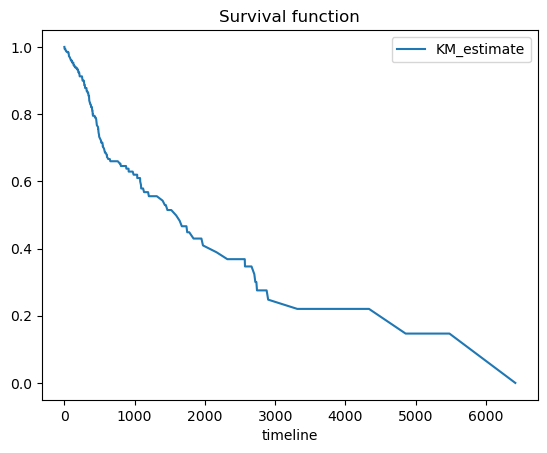

In [13]:
kmf.survival_function_.plot()
plt.title('Survival function')

<Axes: xlabel='timeline'>

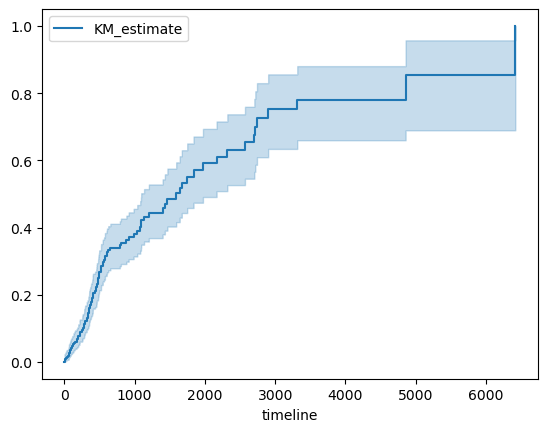

In [14]:
kmf.plot_cumulative_density()

In [15]:
from lifelines.utils import median_survival_times
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print(median_confidence_interval_)

1591.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                  1093.0                  2166.0


Text(0.5, 1.0, 'Survival of different gender group')

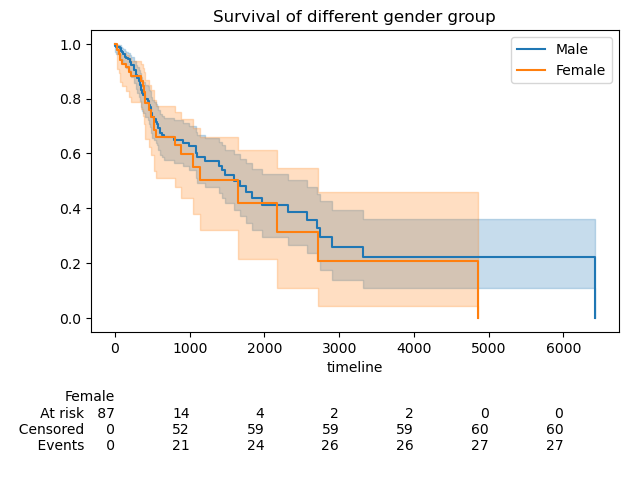

In [16]:
ax = plt.subplot(111)
m = (data_cleaned["sex"] == 0)
kmf.fit(durations = T[m], event_observed = E[m], label = "Male")
kmf.plot_survival_function(ax = ax)
kmf.fit(T[~m], event_observed = E[~m], label = "Female")
kmf.plot_survival_function(ax = ax, at_risk_counts = True)
plt.title("Survival of different gender group")

Text(0.5, 1.0, 'Survival of different node group')

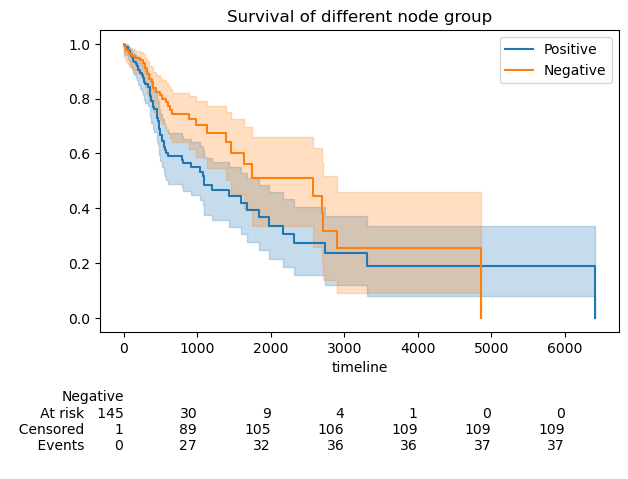

In [17]:
ax = plt.subplot(111)
p = (data_cleaned["node"] == 2)
kmf.fit(durations = T[p], event_observed = E[p], label = "Positive")
kmf.plot_survival_function(ax = ax)
kmf.fit(T[~p], event_observed = E[~p], label = "Negative")
kmf.plot_survival_function(ax = ax, at_risk_counts = True)
plt.title("Survival of different node group")

In [18]:
data_cleaned.head()

,node,sex,race,ethnicity,history_other_malignancy.x,margin_status,status,age,hpv_status,site,...,TWIST1_7291,UCHL1_7345,VAV1_7409,VIM_7431,WIF1_11197,WISP1_8840,ZAP70_7535,ZCCHC14_23174,ZMYND10_51364,ZNF582_147948
Index,,,,,,,,,,,,,,,,,,,,,
2,2,0,4.0,2.0,1,3.0,1,69,1,2,...,292.1193,554.5643,36.6113,14629.8601,0.7708,701.7801,82.0863,251.2689,5.0100,16.9568
3,1,0,3.0,2.0,2,3.0,1,49,1,2,...,144.7139,209.5672,52.5258,5891.3842,0.0000,207.9593,3.7518,311.9389,9.1116,4.2878
5,1,1,4.0,2.0,2,1.0,1,45,2,3,...,144.8508,1848.4119,361.4052,13008.3397,19.7305,98.6526,118.3831,501.9249,1.9249,8.1809
7,2,0,4.0,2.0,1,1.0,0,47,1,2,...,114.3053,34.5654,73.2375,26226.9576,0.0000,151.2663,43.4634,2098.9049,7.1869,2.0534
8,1,0,4.0,2.0,1,2.0,0,72,1,2,...,116.3442,10.9406,119.5464,8067.4263,5.3369,512.8753,75.2502,938.2255,1.8679,4.8032


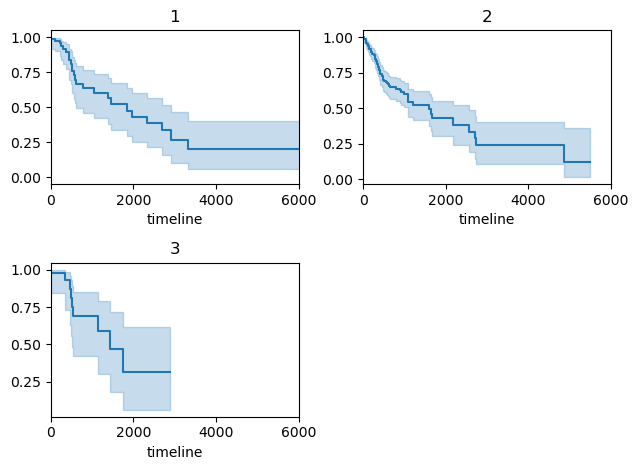

In [19]:
site_types = data_cleaned.sort_values(by = ['site'])["site"].unique()
for i, site_types in enumerate(site_types):
  ax = plt.subplot(2, 2, i + 1)
  ix = data_cleaned['site'] == site_types
  kmf.fit(T[ix], E[ix], label = site_types)
  kmf.plot_survival_function(ax = ax, legend = False)
  plt.title(site_types)
  plt.xlim(0, 6000)
plt.tight_layout()

In [20]:
data_cleaned['site'].value_counts()

site
2    221
1     80
3     43
Name: count, dtype: int64

In [21]:
data_cleaned.head()

,node,sex,race,ethnicity,history_other_malignancy.x,margin_status,status,age,hpv_status,site,...,TWIST1_7291,UCHL1_7345,VAV1_7409,VIM_7431,WIF1_11197,WISP1_8840,ZAP70_7535,ZCCHC14_23174,ZMYND10_51364,ZNF582_147948
Index,,,,,,,,,,,,,,,,,,,,,
2,2,0,4.0,2.0,1,3.0,1,69,1,2,...,292.1193,554.5643,36.6113,14629.8601,0.7708,701.7801,82.0863,251.2689,5.0100,16.9568
3,1,0,3.0,2.0,2,3.0,1,49,1,2,...,144.7139,209.5672,52.5258,5891.3842,0.0000,207.9593,3.7518,311.9389,9.1116,4.2878
5,1,1,4.0,2.0,2,1.0,1,45,2,3,...,144.8508,1848.4119,361.4052,13008.3397,19.7305,98.6526,118.3831,501.9249,1.9249,8.1809
7,2,0,4.0,2.0,1,1.0,0,47,1,2,...,114.3053,34.5654,73.2375,26226.9576,0.0000,151.2663,43.4634,2098.9049,7.1869,2.0534
8,1,0,4.0,2.0,1,2.0,0,72,1,2,...,116.3442,10.9406,119.5464,8067.4263,5.3369,512.8753,75.2502,938.2255,1.8679,4.8032


In [22]:
#set dummy variables
dummies_race= pd.get_dummies(data_cleaned["race"], prefix = 'race')
dummies_race.head(4)

,race_1.0,race_2.0,race_3.0,race_4.0
Index,,,,
2,False,False,False,True
3,False,False,True,False
5,False,False,False,True
7,False,False,False,True


In [23]:
dummies_race = dummies_race[["race_1.0", "race_2.0","race_3.0","race_4.0"]]
data_cleaned = pd.concat([data_cleaned, dummies_race], axis = 1)
data_cleaned = data_cleaned.drop("race", axis = 1)
data_cleaned.head()

,node,sex,ethnicity,history_other_malignancy.x,margin_status,status,age,hpv_status,site,ever_smoker,...,WIF1_11197,WISP1_8840,ZAP70_7535,ZCCHC14_23174,ZMYND10_51364,ZNF582_147948,race_1.0,race_2.0,race_3.0,race_4.0
Index,,,,,,,,,,,,,,,,,,,,,
2,2,0,2.0,1,3.0,1,69,1,2,2.0,...,0.7708,701.7801,82.0863,251.2689,5.0100,16.9568,False,False,False,True
3,1,0,2.0,2,3.0,1,49,1,2,2.0,...,0.0000,207.9593,3.7518,311.9389,9.1116,4.2878,False,False,True,False
5,1,1,2.0,2,1.0,1,45,2,3,2.0,...,19.7305,98.6526,118.3831,501.9249,1.9249,8.1809,False,False,False,True
7,2,0,2.0,1,1.0,0,47,1,2,2.0,...,0.0000,151.2663,43.4634,2098.9049,7.1869,2.0534,False,False,False,True
8,1,0,2.0,1,2.0,0,72,1,2,2.0,...,5.3369,512.8753,75.2502,938.2255,1.8679,4.8032,False,False,False,True


In [24]:
#set dummy variables
dummies_margin_status= pd.get_dummies(data_cleaned["margin_status"], prefix = 'margin_status')
dummies_margin_status.head(10)

,margin_status_1.0,margin_status_2.0,margin_status_3.0
Index,,,
2,False,False,True
3,False,False,True
5,True,False,False
7,True,False,False
8,False,True,False
9,True,False,False
11,True,False,False
17,False,True,False
22,True,False,False


In [25]:
dummies_margin_status = dummies_margin_status[["margin_status_1.0", "margin_status_2.0","margin_status_3.0"]]
data_cleaned = pd.concat([data_cleaned, dummies_margin_status], axis = 1)
data_cleaned = data_cleaned.drop("margin_status", axis = 1)
data_cleaned.head()

,node,sex,ethnicity,history_other_malignancy.x,status,age,hpv_status,site,ever_smoker,time,...,ZCCHC14_23174,ZMYND10_51364,ZNF582_147948,race_1.0,race_2.0,race_3.0,race_4.0,margin_status_1.0,margin_status_2.0,margin_status_3.0
Index,,,,,,,,,,,,,,,,,,,,,
2,2,0,2.0,1,1,69,1,2,2.0,462.0,...,251.2689,5.0100,16.9568,False,False,False,True,False,False,True
3,1,0,2.0,2,1,49,1,2,2.0,283.0,...,311.9389,9.1116,4.2878,False,False,True,False,False,False,True
5,1,1,2.0,2,1,45,2,3,2.0,1134.0,...,501.9249,1.9249,8.1809,False,False,False,True,True,False,False
7,2,0,2.0,1,0,47,1,2,2.0,248.0,...,2098.9049,7.1869,2.0534,False,False,False,True,True,False,False
8,1,0,2.0,1,0,72,1,2,2.0,190.0,...,938.2255,1.8679,4.8032,False,False,False,True,False,True,False


In [26]:
#set dummy variables
dummies_site= pd.get_dummies(data_cleaned["site"], prefix = 'site')
dummies_site.head(10)

,site_1,site_2,site_3
Index,,,
2,False,True,False
3,False,True,False
5,False,False,True
7,False,True,False
8,False,True,False
9,False,True,False
11,True,False,False
17,True,False,False
22,False,True,False


In [27]:
dummies_site = dummies_site[["site_1", "site_2","site_3"]]
data_cleaned = pd.concat([data_cleaned, dummies_site], axis = 1)
data_cleaned = data_cleaned.drop("site", axis = 1)
data_cleaned.head()

,node,sex,ethnicity,history_other_malignancy.x,status,age,hpv_status,ever_smoker,time,ADAM23_8745,...,race_1.0,race_2.0,race_3.0,race_4.0,margin_status_1.0,margin_status_2.0,margin_status_3.0,site_1,site_2,site_3
Index,,,,,,,,,,,,,,,,,,,,,
2,2,0,2.0,1,1,69,1,2.0,462.0,114.4584,...,False,False,False,True,False,False,True,False,True,False
3,1,0,2.0,2,1,49,1,2.0,283.0,12.3275,...,False,False,True,False,False,False,True,False,True,False
5,1,1,2.0,2,1,45,2,2.0,1134.0,774.3022,...,False,False,False,True,True,False,False,False,False,True
7,2,0,2.0,1,0,47,1,2.0,248.0,23.2717,...,False,False,False,True,True,False,False,False,True,False
8,1,0,2.0,1,0,72,1,2.0,190.0,455.7705,...,False,False,False,True,False,True,False,False,True,False


In [28]:
data_cleaned.isna().sum()

node                          0
sex                           0
ethnicity                     0
history_other_malignancy.x    0
status                        0
                             ..
margin_status_2.0             0
margin_status_3.0             0
site_1                        0
site_2                        0
site_3                        0
Length: 169, dtype: int64

In [29]:
data_cleaned.isnull().values.sum()

0

In [30]:
data_cleaned.replace({False: 0, True: 1}, inplace=True)

In [31]:
data_cleaned.head(10)

,node,sex,ethnicity,history_other_malignancy.x,status,age,hpv_status,ever_smoker,time,ADAM23_8745,...,race_1.0,race_2.0,race_3.0,race_4.0,margin_status_1.0,margin_status_2.0,margin_status_3.0,site_1,site_2,site_3
Index,,,,,,,,,,,,,,,,,,,,,
2,2,0,2.0,1,1,69,1,2.0,462.0,114.4584,...,0,0,0,1,0,0,1,0,1,0
3,1,0,2.0,2,1,49,1,2.0,283.0,12.3275,...,0,0,1,0,0,0,1,0,1,0
5,1,1,2.0,2,1,45,2,2.0,1134.0,774.3022,...,0,0,0,1,1,0,0,0,0,1
7,2,0,2.0,1,0,47,1,2.0,248.0,23.2717,...,0,0,0,1,1,0,0,0,1,0
8,1,0,2.0,1,0,72,1,2.0,190.0,455.7705,...,0,0,0,1,0,1,0,0,1,0
9,1,0,2.0,1,0,56,2,1.0,846.0,111.3464,...,0,0,0,1,1,0,0,0,1,0
11,2,0,2.0,1,0,54,1,2.0,186.0,761.5509,...,0,0,1,0,1,0,0,1,0,0
17,1,0,2.0,1,0,62,1,2.0,244.0,2438.0875,...,0,0,0,1,0,1,0,1,0,0
22,2,0,2.0,1,0,61,1,2.0,236.0,176.1697,...,0,0,0,1,1,0,0,0,1,0


In [32]:
from lifelines import CoxPHFitter

In [33]:
cph = CoxPHFitter()

In [34]:
data_cleaned = data_cleaned.drop(['race_1.0'], axis = 1)

In [35]:
data_cleaned.head()

,node,sex,ethnicity,history_other_malignancy.x,status,age,hpv_status,ever_smoker,time,ADAM23_8745,...,ZNF582_147948,race_2.0,race_3.0,race_4.0,margin_status_1.0,margin_status_2.0,margin_status_3.0,site_1,site_2,site_3
Index,,,,,,,,,,,,,,,,,,,,,
2,2,0,2.0,1,1,69,1,2.0,462.0,114.4584,...,16.9568,0,0,1,0,0,1,0,1,0
3,1,0,2.0,2,1,49,1,2.0,283.0,12.3275,...,4.2878,0,1,0,0,0,1,0,1,0
5,1,1,2.0,2,1,45,2,2.0,1134.0,774.3022,...,8.1809,0,0,1,1,0,0,0,0,1
7,2,0,2.0,1,0,47,1,2.0,248.0,23.2717,...,2.0534,0,0,1,1,0,0,0,1,0
8,1,0,2.0,1,0,72,1,2.0,190.0,455.7705,...,4.8032,0,0,1,0,1,0,0,1,0


In [36]:
data_cleaned['time'] = data_cleaned['time'].astype(int)

In [37]:
data_cleaned.head()

,node,sex,ethnicity,history_other_malignancy.x,status,age,hpv_status,ever_smoker,time,ADAM23_8745,...,ZNF582_147948,race_2.0,race_3.0,race_4.0,margin_status_1.0,margin_status_2.0,margin_status_3.0,site_1,site_2,site_3
Index,,,,,,,,,,,,,,,,,,,,,
2,2,0,2.0,1,1,69,1,2.0,462,114.4584,...,16.9568,0,0,1,0,0,1,0,1,0
3,1,0,2.0,2,1,49,1,2.0,283,12.3275,...,4.2878,0,1,0,0,0,1,0,1,0
5,1,1,2.0,2,1,45,2,2.0,1134,774.3022,...,8.1809,0,0,1,1,0,0,0,0,1
7,2,0,2.0,1,0,47,1,2.0,248,23.2717,...,2.0534,0,0,1,1,0,0,0,1,0
8,1,0,2.0,1,0,72,1,2.0,190,455.7705,...,4.8032,0,0,1,0,1,0,0,1,0


In [38]:
data_cleaned.isnull().values.sum()

0

In [39]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 344 entries, 2 to 516
Columns: 168 entries, node to site_3
dtypes: category(7), float64(150), int32(1), int64(10)
memory usage: 437.2 KB


In [40]:
data_cleaned.isnull().values.any()

False

In [41]:
data_cleaned.to_csv('file1.csv')

In [42]:
data_cleaned_new= pd.read_csv('file1.csv')

In [55]:
data_cleaned_new.head()

,Index,node,sex,ethnicity,history_other_malignancy.x,status,age,hpv_status,ever_smoker,time,...,ZNF582_147948,race_2.0,race_3.0,race_4.0,margin_status_1.0,margin_status_2.0,margin_status_3.0,site_1,site_2,site_3
0,2,2,0,2.0,1,1,69,1,2.0,462,...,16.9568,0,0,1,0,0,1,0,1,0
1,3,1,0,2.0,2,1,49,1,2.0,283,...,4.2878,0,1,0,0,0,1,0,1,0
2,5,1,1,2.0,2,1,45,2,2.0,1134,...,8.1809,0,0,1,1,0,0,0,0,1
3,7,2,0,2.0,1,0,47,1,2.0,248,...,2.0534,0,0,1,1,0,0,0,1,0
4,8,1,0,2.0,1,0,72,1,2.0,190,...,4.8032,0,0,1,0,1,0,0,1,0


In [56]:
from lifelines import WeibullFitter,\
                      ExponentialFitter,\
                      LogNormalFitter,\
                      LogLogisticFitter
# Instantiate each fitter
wb = WeibullFitter()
ex = ExponentialFitter()
log = LogNormalFitter()
loglogis = LogLogisticFitter()
# Fit to data
for model in [wb, ex, log, loglogis]:
    model.fit(durations = data_cleaned_new["time"], event_observed = data_cleaned_new["status"])
# Print AIC
print("The AIC value for", model.__class__.__name__, "is",  model.AIC_)

ValueError: This model does not allow for non-positive durations. Suggestion: add a small positive value to zero elements.

In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
  
# the independent variables set 
X = data_cleaned_new
  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  
print(vif_data)

                        feature       VIF
0                         Index  2.709354
1                          node  2.351873
2                           sex  1.786860
3                     ethnicity  2.265578
4    history_other_malignancy.x  1.433831
..                          ...       ...
164           margin_status_2.0       inf
165           margin_status_3.0       inf
166                      site_1       inf
167                      site_2       inf
168                      site_3       inf

[169 rows x 2 columns]


In [46]:
vif_data.to_csv("file2.csv")

In [47]:
data_cleaned_new.head()

,Index,node,sex,ethnicity,history_other_malignancy.x,status,age,hpv_status,ever_smoker,time,...,ZNF582_147948,race_2.0,race_3.0,race_4.0,margin_status_1.0,margin_status_2.0,margin_status_3.0,site_1,site_2,site_3
0,2,2,0,2.0,1,1,69,1,2.0,462,...,16.9568,0,0,1,0,0,1,0,1,0
1,3,1,0,2.0,2,1,49,1,2.0,283,...,4.2878,0,1,0,0,0,1,0,1,0
2,5,1,1,2.0,2,1,45,2,2.0,1134,...,8.1809,0,0,1,1,0,0,0,0,1
3,7,2,0,2.0,1,0,47,1,2.0,248,...,2.0534,0,0,1,1,0,0,0,1,0
4,8,1,0,2.0,1,0,72,1,2.0,190,...,4.8032,0,0,1,0,1,0,0,1,0


In [48]:
data_cleaned_new.to_csv("file3.csv")

In [58]:
data_cleaned_new2 = pd.read_csv('file3.csv')

In [61]:
data_cleaned_new2.head()

,node,sex,ethnicity,history_other_malignancy.x,status,age,hpv_status,ever_smoker,time,ADAM23_8745,...,ZNF582_147948,race_2.0,race_3.0,race_4.0,margin_status_1.0,margin_status_2.0,margin_status_3.0,site_1,site_2,site_3
0,2,0,2,1,1,69,1,2,462,114.4584,...,16.9568,0,0,1,0,0,1,0,1,0
1,1,0,2,2,1,49,1,2,283,12.3275,...,4.2878,0,1,0,0,0,1,0,1,0
2,1,1,2,2,1,45,2,2,1134,774.3022,...,8.1809,0,0,1,1,0,0,0,0,1
3,2,0,2,1,0,47,1,2,248,23.2717,...,2.0534,0,0,1,1,0,0,0,1,0
4,1,0,2,1,0,72,1,2,190,455.7705,...,4.8032,0,0,1,0,1,0,0,1,0


In [63]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(data_cleaned_new, duration_col = 'time', event_col = 'status')
cph.print_summary()

ConvergenceError: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.

AttributeError: Must call `fit` first.

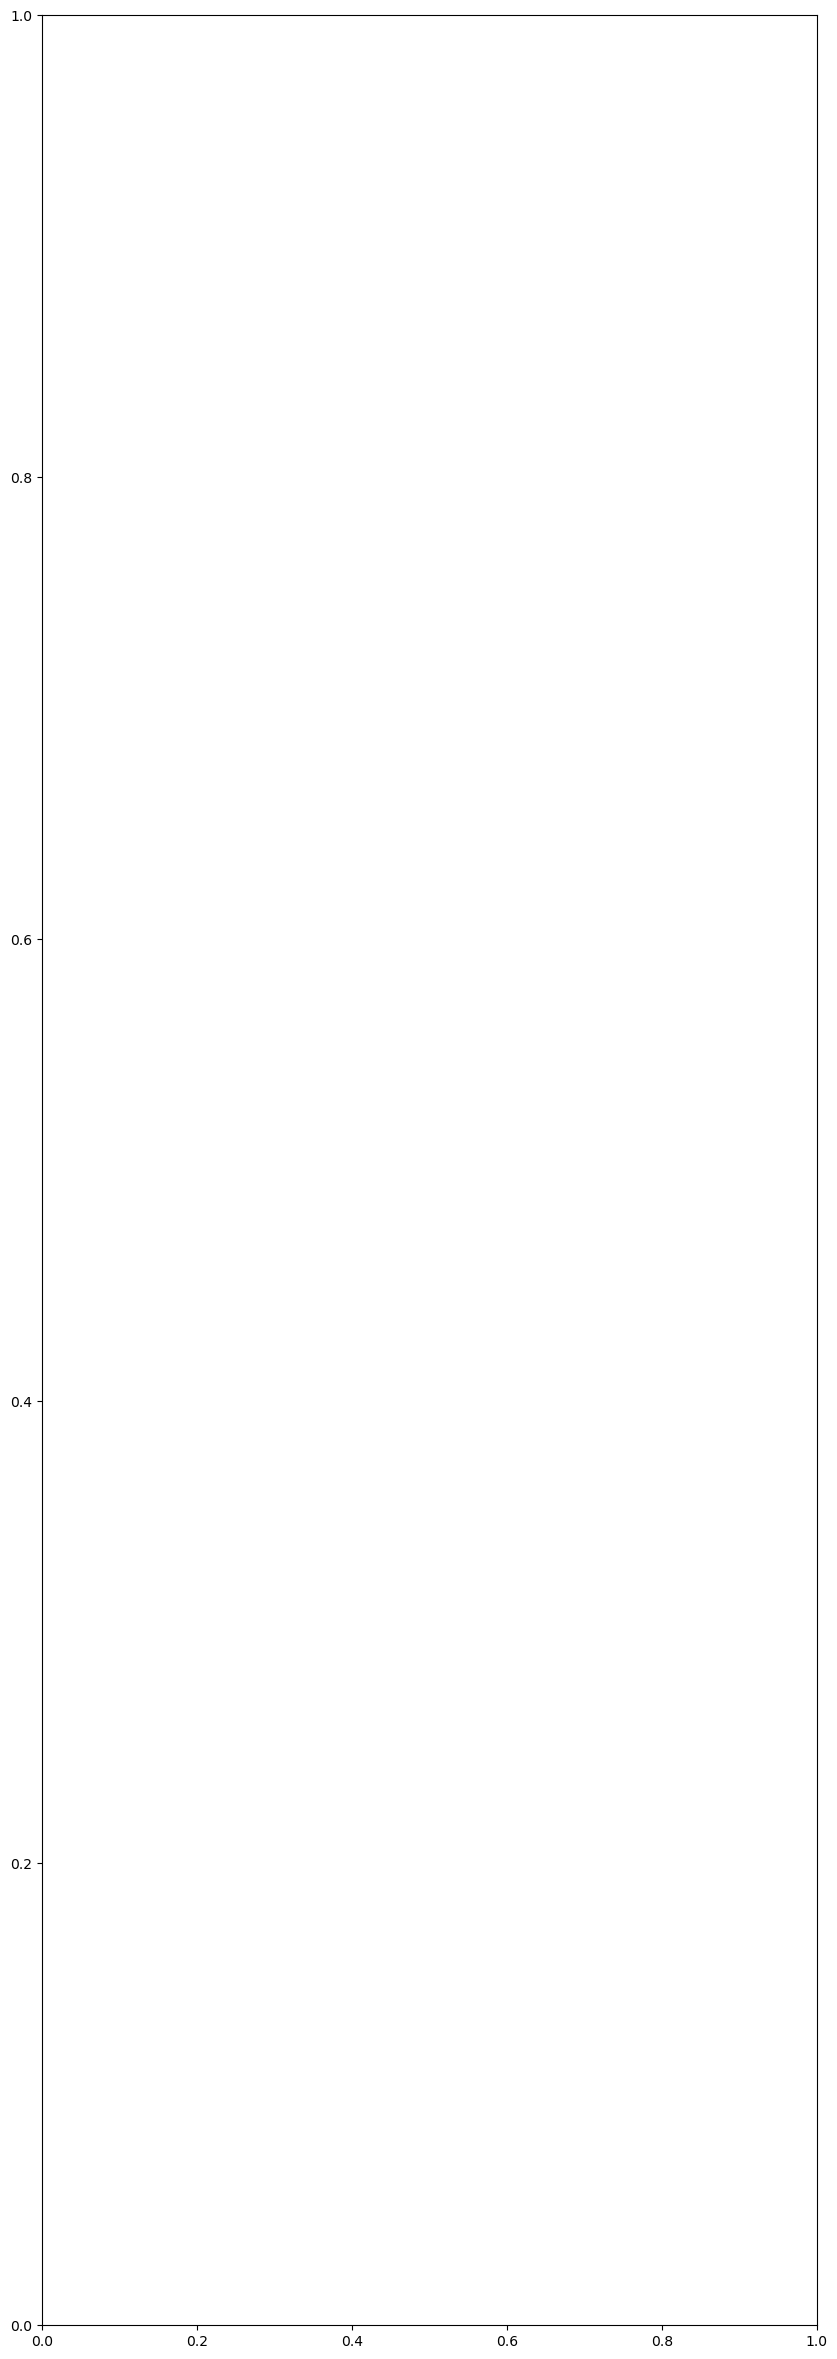

In [52]:
plt.subplots(figsize = (10, 30))
cph.plot()

In [53]:
cph.plot_partial_effects_on_outcome(covariates = 'age', values = [40,50, 60, 70, 80,90], cmap = 'coolwarm')

AttributeError: Must call `fit` first.

In [ ]:
cph.plot_partial_effects_on_outcome(covariates = 'node', values = [0,1], cmap = 'coolwarm')

In [ ]:
cph.check_assumptions(data_cleaned_new2, p_value_threshold = 0.05)

In [ ]:
from lifelines.statistics import proportional_hazard_test
results = proportional_hazard_test(cph, data_cleaned_new2, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

In [ ]:
from lifelines import WeibullFitter,\
                      ExponentialFitter,\
                      LogNormalFitter,\
                      LogLogisticFitter
# Instantiate each fitter
wb = WeibullFitter()
ex = ExponentialFitter()
log = LogNormalFitter()
loglogis = LogLogisticFitter()
# Fit to data
for model in [wb, ex, log, loglogis]:
    model.fit(durations = data_cleaned_new2["time"], event_observed = data_cleaned_new2["status"])
    # Print AIC
    print("The AIC value for", model.__class__.__name__, "is",  model.AIC_)


In [ ]:
from lifelines import WeibullAFTFitter
weibull_aft = WeibullAFTFitter()
weibull_aft.fit(data_cleaned_new2['time'], data_cleaned_new2['status'])
weibull_aft.print_summary(3)